In [200]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import ast
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import shap
import umap

movies = pd.read_csv('movies_main.csv')
movies.head()

,title,release_date,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,budget,revenue,sentiment,release_year,release_month,release_week,thanksgiving_release,christmas_release,production_level
0,Four Rooms,12/9/1995,"['Miramax', 'A Band Apart']",['Comedy'],15.843,5.853,2639,It's Ted the Bellhop's first night on the job....,No reviews available,4000000,4301000,0.0000,1995,12,49,0,0,Mid
1,Finding Nemo,5/30/2003,['Pixar'],"['Animation', 'Family']",97.427,7.820,19227,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,94000000,936094852,0.9976,2003,5,22,0,0,Top
2,Forrest Gump,6/23/1994,"['Paramount Pictures', 'The Steve Tisch Compan...","['Comedy', 'Drama', 'Romance']",95.507,8.470,27470,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,55000000,679835137,0.9963,1994,6,25,0,0,Mid
3,American Beauty,9/15/1999,"['DreamWorks Pictures', 'Jinks/Cohen Company']",['Drama'],31.884,8.000,12017,"Lester Burnham, a depressed suburban father in...",The film American Beauty to me is a film about...,15000000,356258047,0.9922,1999,9,37,0,0,Mid
4,Dancer in the Dark,9/1/2000,"['Zentropa Entertainments', 'DR', 'SVT Drama',...","['Drama', 'Crime']",16.923,7.878,1780,"Selma, a Czech immigrant on the verge of blind...",Dazzling Björk in this indictment against the ...,12500000,45556774,-0.5574,2000,9,35,0,0,Low


In [201]:
# Convert string representations of lists back into actual lists
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

movies['production_companies'] = movies['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [202]:
movies['log_revenue'] = np.log1p(movies['revenue'])
movies['log_budget'] = np.log1p(movies['budget'])

##### Log Revenue Standard Deviation

In [203]:
movies['log_revenue'].std()

1.5104461928786173

### Pre-processing the data and gettin it ready

In [204]:
# Step 1: Fit the MultiLabelBinarizer on the genres data (on the entire dataset)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Create a DataFrame from the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Concatenate the genre DataFrame with the original dataset
movies = pd.concat([movies, genres_df], axis=1)
movies.head()

,title,release_date,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,budget,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Four Rooms,12/9/1995,"[Miramax, A Band Apart]",[Comedy],15.843,5.853,2639,It's Ted the Bellhop's first night on the job....,No reviews available,4000000,...,0,0,0,0,0,0,0,0,0,0
1,Finding Nemo,5/30/2003,[Pixar],"[Animation, Family]",97.427,7.820,19227,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,94000000,...,0,0,0,0,0,0,0,0,0,0
2,Forrest Gump,6/23/1994,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",95.507,8.470,27470,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,55000000,...,0,0,0,0,1,0,0,0,0,0
3,American Beauty,9/15/1999,"[DreamWorks Pictures, Jinks/Cohen Company]",[Drama],31.884,8.000,12017,"Lester Burnham, a depressed suburban father in...",The film American Beauty to me is a film about...,15000000,...,0,0,0,0,0,0,0,0,0,0
4,Dancer in the Dark,9/1/2000,"[Zentropa Entertainments, DR, SVT Drama, ARTE,...","[Drama, Crime]",16.923,7.878,1780,"Selma, a Czech immigrant on the verge of blind...",Dazzling Björk in this indictment against the ...,12500000,...,0,0,0,0,0,0,0,0,0,0


In [205]:
movie_titles = movies['title']
X = movies.drop(columns=['revenue', 'budget','title', 'overview', 'reviews', 'genres', 'release_date'])  # Features
y = movies['log_revenue']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the categorical and numerical columns
categorical_cols = ['production_level']  # Only 'production_level' as a categorical variable
numerical_cols = ['log_budget', 'popularity', 'vote_average', 'vote_count', 'sentiment', 
                  'release_year', 'release_month', 'release_week', 'thanksgiving_release', 'christmas_release'] + list(mlb.classes_)

# Columns for polynomial features
poly_cols = ['log_budget', 'popularity', 'vote_count', 'vote_average', 'sentiment']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # Apply polynomial features to selected numerical columns
        ('poly', Pipeline([
            ('scaler', StandardScaler()),  # Scale these features
            ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Add polynomial features
        ]), poly_cols),

        # Apply scaling to remaining numerical columns
        ('num', StandardScaler(), [col for col in numerical_cols if col not in poly_cols]),

        # One-hot encode categorical features
        ('cat', OneHotEncoder(), categorical_cols)
    ])

#### Fitting a random Forest

In [206]:
# Define the model pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators= 200, random_state=42))
])

# Fit the pipeline to the training data
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate Mean Squared Error
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)  

print(f'Root Mean Squared Error (Random Forest): {rmse_rf}')

Root Mean Squared Error (Random Forest): 0.9581619581825935


### Fitting a Ridge/Lasso/EN Pipeline

In [207]:
model_ridgecv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV())
])
# Fit the pipeline to the training data
model_ridgecv.fit(X_train, y_train)

# Predict on the test set
y_pred_ridgecv = model_ridgecv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_ridgecv = root_mean_squared_error(y_test, y_pred_ridgecv)

print(f'Root Mean Squared Error (RidgeCV): {rmse_ridgecv}')

Root Mean Squared Error (RidgeCV): 0.9448914147604645


In [208]:
model_lassocv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV())
])
# Fit the pipeline to the training data
model_lassocv.fit(X_train, y_train)

# Predict on the test set
y_pred_lassocv = model_lassocv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_lassocv = root_mean_squared_error(y_test, y_pred_lassocv)

print(f'Root Mean Squared Error (LassoCV): {rmse_lassocv}')

Root Mean Squared Error (LassoCV): 0.9447102048843058


In [209]:
model_encv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV())
])
# Fit the pipeline to the training data
model_encv.fit(X_train, y_train)

# Predict on the test set
y_pred_encv = model_encv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_encv = root_mean_squared_error(y_test, y_pred_encv)

print(f'Root Mean Squared Error (ElasticNetCV): {rmse_encv}')

Root Mean Squared Error (ElasticNetCV): 0.9396337478384655


### XGBoost

In [210]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators= 150,      # Number of boosting rounds
        learning_rate=0.05,     # Step size shrinkage
        max_depth= 4,           # Maximum depth of a tree
        subsample= 0.8,         # Fraction of samples used for training
        colsample_bytree= 0.8,  # Fraction of features used for training
        reg_alpha= 0.25,         # L1 regularization (sparsity)
        reg_lambda= 2,        # L2 regularization (ridge-like penalty)
        random_state=42        # For reproducibility
    ))
])

# Fit the pipeline to the training data
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Calculate Root Mean Squared Error
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)

print(f'Root Mean Squared Error (XGBoost): {rmse_xgb}')

Root Mean Squared Error (XGBoost): 0.8825551306231901


#### Cross Validation with XGB

In [211]:
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv= 300, scoring='neg_root_mean_squared_error')
print(f'Cross-validated RMSE: {-cv_scores.mean()}')

Cross-validated RMSE: 0.8586845738974114


### Fitting an SVM 

In [212]:
model_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C = 5, epsilon = .5))
])

model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

rmse_svm = root_mean_squared_error(y_test, y_pred_svm)

print(f'Root Mean Squared Log Error (SVM): {rmse_svm}')

Root Mean Squared Log Error (SVM): 0.9094989308628769


### Fitting an RNN

In [213]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Reshape data for RNN (RNN expects [samples, timesteps, features])
X_train_processed = X_train_processed.reshape((X_train_processed.shape[0], 1, X_train_processed.shape[1]))
X_test_processed = X_test_processed.reshape((X_test_processed.shape[0], 1, X_test_processed.shape[1]))

# Define the RNN model
model_rnn = Sequential()

# Add a SimpleRNN/LSTM (Tried with both)
model_rnn.add(LSTM(units=100, activation='relu', input_shape=(X_train_processed.shape[1], X_train_processed.shape[2])))

# Add Batch Normalization
model_rnn.add(BatchNormalization())

# Add a Dropout layer to prevent overfitting
model_rnn.add(Dropout(0.5))

# Add a Dense layer for the output (1 output value for regression)
model_rnn.add(Dense(1))

# Compile the model with Mean Squared Error as loss function for regression
model_rnn.compile(optimizer=Adam(learning_rate = 0.01), loss= 'mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train the RNN model
model_rnn.fit(X_train_processed, 
              y_train, 
              epochs= 100, batch_size= 32, 
              validation_data=(X_test_processed, y_test),
              callbacks = [early_stopping, lr_scheduler]
              )

# Predict on the test set
y_pred_rnn = model_rnn.predict(X_test_processed)


# Calculate Root Mean Squared Log Error (RMSE)
rmse_rnn = root_mean_squared_error(y_test, y_pred_rnn)

print(f'Root Mean Squared log Error (RNN): {rmse_rnn}')

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 271.5459 - val_loss: 41.0441 - learning_rate: 0.0100
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.1905 - val_loss: 4.2939 - learning_rate: 0.0100
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.0760 - val_loss: 5.0692 - learning_rate: 0.0100
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.5661 - val_loss: 2.2021 - learning_rate: 0.0100
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5640 - val_loss: 3.5473 - learning_rate: 0.0100
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3216 - val_loss: 1.5966 - learning_rate: 0.0100
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1683 - val_loss: 1.3999 - learning_rate: 0.0100
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7613 - val_loss: 1.3390 - learning_rate: 0.0100
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0718 - val_loss: 1.7299 - learning_rate: 0.0100
Epoch 10/100

### SHAP Analysis

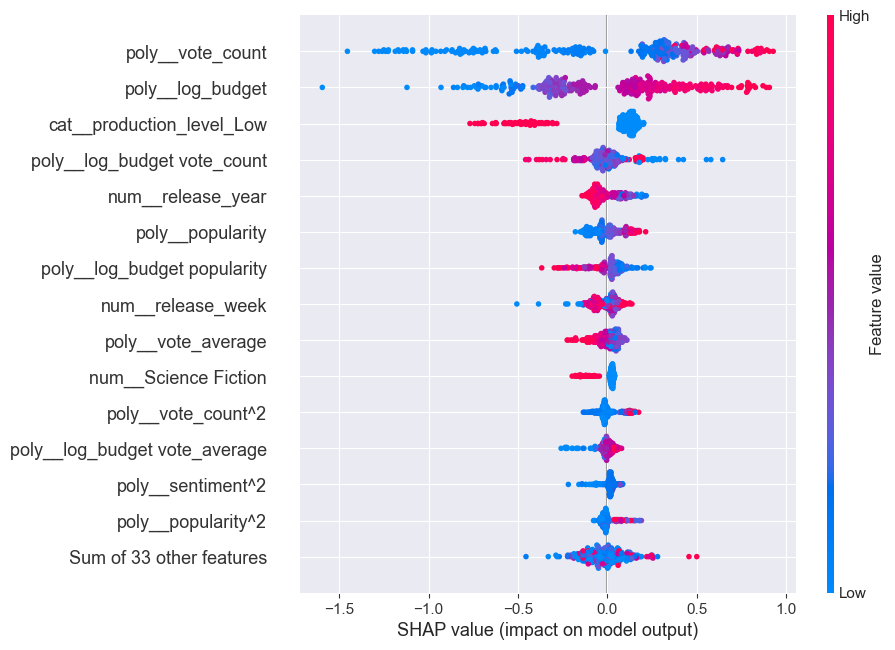

<Figure size 640x480 with 0 Axes>

In [214]:
# Step 1: Preprocess the data (using the same transformation as in your pipeline)
X_test_transformed = model_xgb.named_steps['preprocessor'].transform(X_test)

# Step 3: Initialize SHAP Explainer
explainer = shap.Explainer(model_xgb.named_steps['regressor'], X_test_transformed)

# Step 4: Compute SHAP values
shap_values = explainer(X_test_transformed)

# Step 5: Get feature names (these come from the preprocessor pipeline)
# Categorical features will have their one-hot encoded names
# For example, if the 'production_level' has three possible values, 
# the one-hot encoder will create three new features with the original column name and the class labels.
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()

# Step 6: Beeswarm plot of top 15 features
exp = shap.Explanation(shap_values.values, shap_values.base_values, X_test_transformed, feature_names=feature_names)

# Visualize top 15 most important features
shap.plots.beeswarm(exp, max_display=15)

# Save the plot
plt.savefig('beeswarm_revenue_model.png')
# Show the plot
plt.show()

### Cluster Analysis

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak o

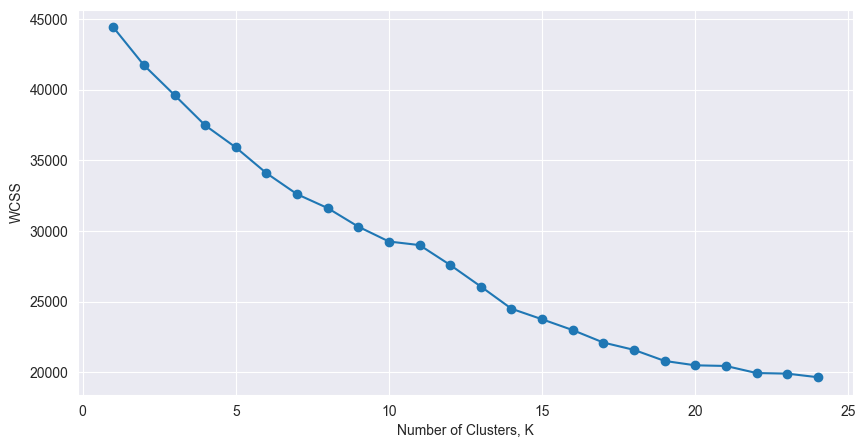

In [215]:
# Clustering Preprocessing: No Polynomial Features
clustering_preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical features without polynomial expansion
        ('num', StandardScaler(), numerical_cols),
        
        # One-hot encode categorical features
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X_processed = clustering_preprocessor.fit_transform(X)

kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(X_processed)
                for k in range(1, 25)]
inertias = [model.inertia_ for model in kmeans_per_k]

# Plot the WCSS to visualize the elbow point
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(inertias))+1,inertias,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS');

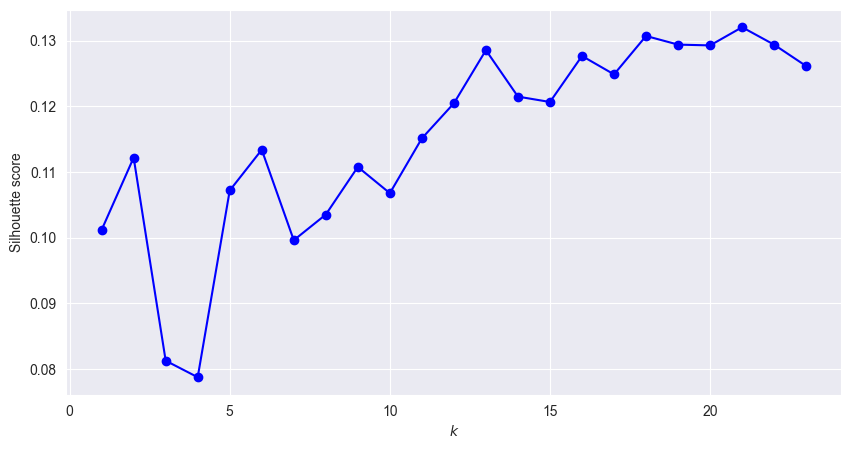

In [216]:
silhouette_scores = [silhouette_score(X_processed, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(silhouette_scores))+1, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



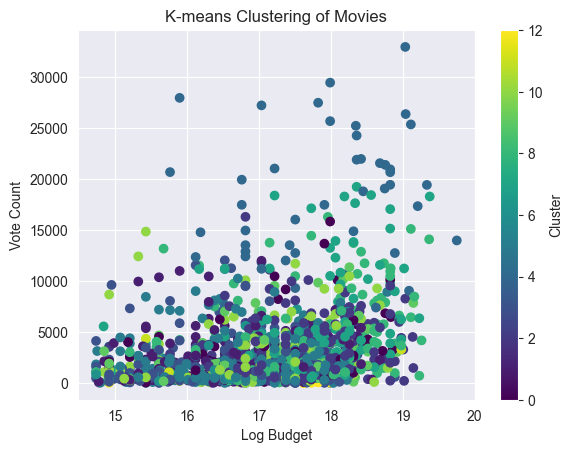

In [217]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=13, random_state=42)  
kmeans.fit(X_processed)

# Get the cluster labels
movies['cluster'] = kmeans.labels_

# Visualize the clusters (you can use a 2D plot or 3D plot depending on your data)
plt.scatter(movies['log_budget'], movies['vote_count'], c=movies['cluster'], cmap='viridis')
plt.xlabel('Log Budget')
plt.ylabel('Vote Count')
plt.title('K-means Clustering of Movies')
plt.colorbar(label='Cluster')
plt.show()

In [218]:
# Cluster centers
cluster_centers = kmeans.cluster_centers_

In [219]:
# Get the feature names after one-hot encoding
# This will combine both numerical and categorical feature names
num_feature_names = numerical_cols
cat_feature_names = clustering_preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Create a DataFrame with the cluster centers for better readability
cluster_centers_df = pd.DataFrame(cluster_centers, columns=feature_names)
print(cluster_centers_df)

    log_budget  popularity  vote_average  vote_count  sentiment  release_year  \
0     0.010318    0.064229      0.514600   -0.044254  -0.286292     -0.356342   
1    -0.412570   -0.202634      0.070637   -0.223002  -0.429023     -0.014785   
2     0.371834   -0.095963     -0.285913   -0.122725   0.007040      0.039464   
3    -0.549324   -0.265359      0.447016   -0.346423  -0.035120     -0.242998   
4     0.711681    3.251555      1.280226    3.401471   0.572073      0.209246   
5    -0.273769   -0.287341     -0.379383   -0.277588  -0.055406      0.209127   
6    -0.488712   -0.419117      0.199819   -0.330689   0.183667      0.224308   
7     0.656151    0.802882      0.029064    0.592293   0.240237      0.190373   
8     0.533313    0.020832     -0.231204    0.228984   0.258453     -0.123005   
9    -0.024528   -0.143331      0.313728   -0.167934   0.191895     -0.274947   
10   -0.073393   -0.215280     -0.211841   -0.125400  -0.026919      0.249811   
11   -0.158413   -0.093296  

### PCA to get Principle componenets for the graph

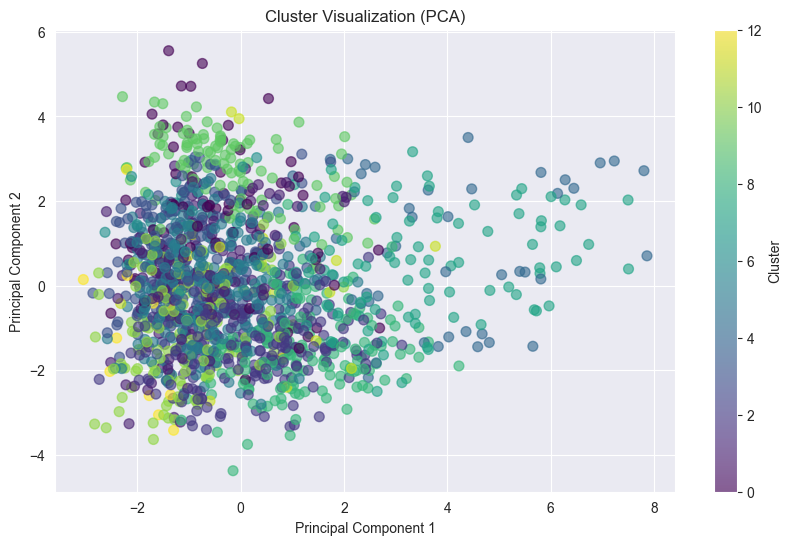

In [220]:
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed) 

# Plot the data points, color-coded by cluster
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.6)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

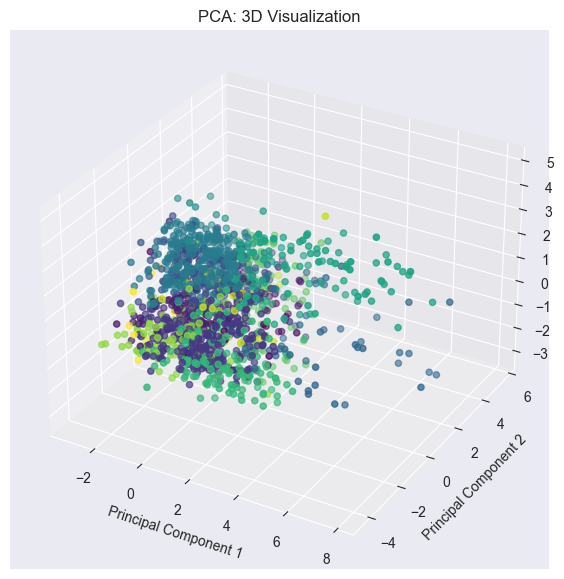

In [221]:
pca3d = PCA(n_components=3)
X_pca = pca.fit_transform(X_processed) 

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the first three principal components
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans.labels_, cmap = 'viridis', marker='o')

# Set labels for axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA: 3D Visualization')

# Show the plot
plt.show()

In [222]:
# Assuming X_pca is the PCA-transformed data and kmeans.labels_ are the cluster labels
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Add the cluster labels to the dataframe for coloring
pca_df['Cluster'] = kmeans.labels_

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', color_continuous_scale= 'viridis',
                    title="PCA: 3D Visualization with Clusters", 
                    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'})

# Show the interactive plot
fig.show()

#### Umap for the graph :)

In [224]:
# Perform UMAP to reduce to 2 dimensions
umap = umap.UMAP(n_components=2, n_neighbors = 30)
X_UMAP = umap.fit_transform(X_processed)  

# Plot the data points, color-coded by cluster
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=10, alpha=0.6)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

AttributeError: 'UMAP' object has no attribute 'UMAP'